In [58]:
import numpy as np
import pandas as pd 
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,BatchNormalization, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint

In [2]:
train_data = pd.read_csv("twitter_training.csv")

validation_data = pd.read_csv("twitter_validation.csv")

In [3]:
train_data.sample(10)


,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
51282,10402,RedDeadRedemption(RDR),Neutral,I'm selling my Xbox One X Special Edition Red ...
69097,3836,Cyberpunk2077,Negative,@ Game I'll just get a refund and wait to rele...
12192,8496,NBA2K,Negative,Your game sucks. @ Ronnie2K @ NBA2K
31022,7329,LeagueOfLegends,Neutral,CGA do the unthinkable.... AGAIN. They move up...
10664,13034,Xbox(Xseries),Negative,bruh if Xbox Series X game cases almost sounds...
1127,2599,Borderlands,Irrelevant,Now that I have a PC and waiting for new games...
22838,4313,CS-GO,Neutral,The Russians on cs:go are starting to invade O...
7582,9303,Overwatch,Positive,Good morning Twitter fam gonna do the gym then...
67022,7077,johnson&johnson,Neutral,Johnson & Johnson announces that it will not s...
55255,2287,CallOfDuty,Neutral,"The flow is over. Gets FiNN Damascus, moved to..."


In [4]:
train_data = train_data.rename(columns={"2401":"ID",
                                        "Borderlands":"Entity",
                                        "Positive":"Labels",
                                        "im getting on borderlands and i will murder you all ,":"Text"})

In [5]:
train_data.shape

(74681, 4)

In [6]:
train_data_dupilcate_sum = train_data.duplicated().sum()
train_data_dupilcate_sum

2700

In [7]:
train_data = train_data.drop_duplicates()

In [8]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 71981 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      71981 non-null  int64 
 1   Entity  71981 non-null  object
 2   Labels  71981 non-null  object
 3   Text    71655 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


In [9]:
train_data.isnull().sum()

ID          0
Entity      0
Labels      0
Text      326
dtype: int64

In [10]:
train_data = train_data.dropna()

In [11]:
train_data["Labels"].value_counts()

Labels
Negative      21698
Positive      19712
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64

In [12]:
validation_data.sample(10)

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
986,4905,GrandTheftAuto(GTA),Irrelevant,The ultimate pruning machine! @stihlusa GTA 26...
760,2952,Dota2,Neutral,Making crappy @Immortals til treasure 3 day 1 ...
742,11610,Verizon,Negative,Funny how this issue is not HUGE during this p...
343,1023,AssassinsCreed,Negative,My experience with ASSASSIN'S CREED: ODYSSEY\n...
120,4574,Google,Negative,Well that's not helping to reassure me my data...
589,7445,LeagueOfLegends,Neutral,.@wandakunpls @Sirhaian Can I just say how fuc...
553,11976,Verizon,Positive,I can get on the phone with @Verizon but I can...
314,7587,LeagueOfLegends,Neutral,‘League Of Legends’ K-pop group K/DA announces...
279,6267,FIFA,Negative,Pissing people off in FIFA and on twitter 😭😭😭
883,11269,TomClancysRainbowSix,Negative,5 years old and it’s in worse condition than B...


In [13]:
validation_data.columns

Index(['3364', 'Facebook', 'Irrelevant',
       'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣'],
      dtype='object')

In [14]:
validation_data = validation_data.rename(columns={"3364":"ID",
                                        "Facebook":"Entity",
                                        "Irrelevant":"Labels",
                                        "I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣":"Text"})

In [15]:
validation_data.shape

(999, 4)

In [16]:
validation_data_dupilcate_sum = validation_data.duplicated().sum()
validation_data_dupilcate_sum

0

In [17]:
validation_data = validation_data.drop_duplicates()

In [18]:
validation_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      999 non-null    int64 
 1   Entity  999 non-null    object
 2   Labels  999 non-null    object
 3   Text    999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [19]:
validation_data.isnull().sum()

ID        0
Entity    0
Labels    0
Text      0
dtype: int64

In [20]:
validation_data["Labels"].value_counts()

Labels
Neutral       285
Positive      277
Negative      266
Irrelevant    171
Name: count, dtype: int64

In [21]:
stop_word = set(stopwords.words("english"))

negation_words = {
    "not", "no", "never", "none", "nobody", "nothing", "neither", "nowhere",
    "hasn't", "haven't", "hadn't", "doesn't", "don't", "didn't",
    "won't", "wouldn't", "can't", "couldn't", "isn't", "aren't", "wasn't", "weren't",
    "without", "nor"
}

filtered_stopwords = stop_word - negation_words

punctuation = set(string.punctuation)

def Preprocessing_text(text):

  text =text.lower()

  text = re.sub(r'<[^>]+>', '', text)

  text = re.sub(r"http\S+|www\S+|https\S+", '', text)

  text = re.sub(r"http\S+", "", text)

  text = re.sub(r"[^\w\s]", "", text)

  text = re.sub(r"\d+" , "" , text)

  text = re.sub(r'\s+', ' ', text).strip()

  words = text.split()

  filtered = [word for word in words if word not in filtered_stopwords]

  return " ".join(filtered)


In [22]:
lemma = WordNetLemmatizer()
def tokenize_lemmatize(text):

    tokens = word_tokenize(text)

    lemma_words = [lemma.lemmatize(word) for word in tokens]

    return " ".join(lemma_words)

In [23]:
train_data["Text"]  = train_data["Text"].apply(Preprocessing_text)

validation_data["Text"]  = validation_data["Text"].apply(Preprocessing_text)


In [24]:
train_data["Text"]  = train_data["Text"].apply(tokenize_lemmatize)

validation_data["Text"]  = validation_data["Text"].apply(tokenize_lemmatize)


In [25]:
train_data["Text"] 

0                                       coming border kill
1                               im getting borderland kill
2                              im coming borderland murder
3                             im getting borderland murder
4                             im getting borderland murder
                               ...                        
74676    realized window partition mac like year behind...
74677    realized mac window partition year behind nvid...
74678    realized window partition mac year behind nvid...
74679    realized window partition mac like year behind...
74680    like window partition mac like year behind dri...
Name: Text, Length: 71655, dtype: object

In [26]:
validation_data["Text"] 

0      bbc news amazon bos jeff bezos reject claim co...
1      microsoft pay word function poorly samsungus c...
2      csgo matchmaking full closet hacking truly awf...
3      president slapping american face really commit...
4      hi eahelp ive madeleine mccann cellar past yea...
                             ...                        
994    toronto art culture capital canada no wonder w...
995    actually good move tot bring viewer one people...
996    today sucked time drink wine n play borderland...
997            bought fraction microsoft today small win
998    johnson johnson stop selling talc baby powder ...
Name: Text, Length: 999, dtype: object

In [27]:
le = LabelEncoder()

train_data["Labels"] = le.fit_transform(train_data["Labels"])
validation_data["Labels"] = le.transform(validation_data["Labels"])

In [28]:
print(le.classes_)


['Irrelevant' 'Negative' 'Neutral' 'Positive']


In [29]:
train_data = train_data.drop(columns=["ID", "Entity"] , axis=1)
validation_data = validation_data.drop(columns=["ID", "Entity"] , axis=1)

In [30]:
train , test = train_test_split(train_data , test_size=0.1,random_state=42 , stratify=train_data["Labels"])

In [31]:
x_train = train["Text"]
x_val = validation_data["Text"]
x_test  = test["Text"]

y_train = train["Labels"]

y_val = validation_data["Labels"]

y_test = test["Labels"]


In [32]:
classes = np.array([0, 1, 2, 3])  

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train  
)

class_weights = dict(zip(classes, class_weights))
print(class_weights)


{0: 1.4288974563502614, 1: 0.8255965792707907, 2: 1.0116238940829516, 3: 0.908756552618229}


In [33]:
y_train_categorical = to_categorical(y_train)

y_val_categorical  = to_categorical(y_val)

y_test_categorical = to_categorical(y_test)

In [34]:
y_train.value_counts()

Labels
1    19528
3    17741
2    15937
0    11283
Name: count, dtype: int64

In [35]:
max_words=20000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)


In [36]:
import numpy as np

x_train_seq = tokenizer.texts_to_sequences(x_train)

lengths = [len(seq) for seq in x_train_seq]

print("Max length:", np.max(lengths))
print("Average length:", np.mean(lengths))
print("Median length:", np.median(lengths))
print("95th percentile length:", np.percentile(lengths, 95))


Max length: 163
Average length: 11.052954767479726
Median length: 9.0
95th percentile length: 27.0


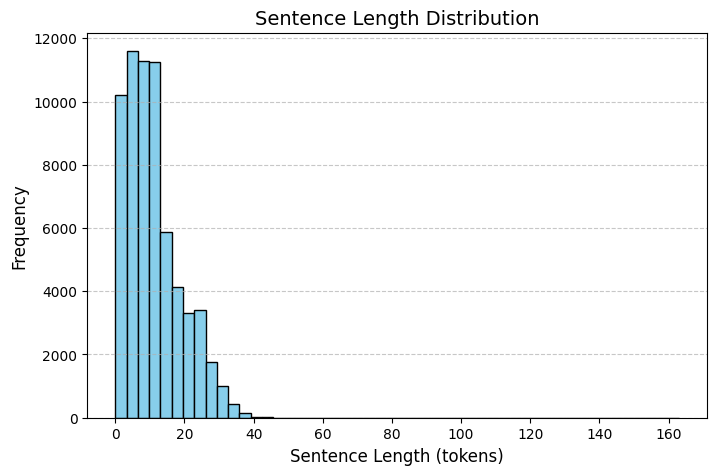

In [37]:
import numpy as np
import matplotlib.pyplot as plt


# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Sentence Length Distribution", fontsize=14)
plt.xlabel("Sentence Length (tokens)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [38]:
max_len = 25

x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post', truncating='post')
x_val_pad   = pad_sequences(x_val_seq,   maxlen=max_len, padding='post', truncating='post')
x_test_pad  = pad_sequences(x_test_seq,  maxlen=max_len, padding='post', truncating='post')


In [39]:
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
    
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)  
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual Connection

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Residual Connection


class TransformerEncoder(layers.Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.layers_list = [
            TransformerEncoderLayer(embed_dim, num_heads, ff_dim, rate)
            for _ in range(num_layers)
        ]

    def call(self, inputs, training):
        x = inputs
        for layer in self.layers_list:
            x = layer(x, training=training)
        return x


class TransformerClassifier(tf.keras.Model):
    def __init__(self, vocab_size, max_len, num_layers, embed_dim, num_heads, ff_dim, num_classes, rate=0.1):
        super().__init__()
        self.embedding = layers.Embedding(vocab_size, embed_dim, input_length=max_len)
        self.pos_encoding = self.positional_encoding(max_len, embed_dim)
        self.encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim, rate)
        self.global_pool = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(rate)
        self.fc = layers.Dense(num_classes, activation="softmax")
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        angle_rads = tf.concat([tf.expand_dims(sines, -1), tf.expand_dims(cosines, -1)], axis=-1)
        angle_rads = tf.reshape(angle_rads, [position, d_model])
        return tf.cast(angle_rads[tf.newaxis, ...], dtype=tf.float32)


    def get_angles(self, pos, i, d_model):
        pos = tf.cast(pos, tf.float32)
        i = tf.cast(i, tf.float32)
        return pos / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :tf.shape(x)[1], :]
        x = self.encoder(x, training=training)
        x = self.global_pool(x)
        x = self.dropout(x, training=training)
        return self.fc(x)



vocab_size = len(tokenizer.word_index) + 1
max_len = 25
num_layers = 6
embed_dim = 128
num_heads = 8
ff_dim = 256
num_classes = 4

model = TransformerClassifier(vocab_size, max_len, num_layers, embed_dim, num_heads, ff_dim, num_classes)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.build(input_shape=(None, max_len))
model.summary()


Model: "transformer_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  4226432   
                                                                 
 transformer_encoder (Transf  multiple                 3563520   
 ormerEncoder)                                                   
                                                                 
 global_average_pooling1d (G  multiple                 0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_12 (Dropout)        multiple                  0         
                                                                 
 dense_12 (Dense)            multiple                  516       
                                                                 
Total params: 7,790,468
Trainable params: 7,

In [40]:
batch_size = 128
epochs = 100
callbacks = [
    EarlyStopping(monitor="val_loss", patience=11, restore_best_weights=True, verbose=1),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    x_train_pad, y_train_categorical,
    validation_data=(x_val_pad, y_val_categorical),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/100
504/504 [==============================] - 48s 83ms/step - loss: 1.4273 - accuracy: 0.2582 - val_loss: 1.2573 - val_accuracy: 0.3944
Epoch 2/100
504/504 [==============================] - 41s 81ms/step - loss: 1.1813 - accuracy: 0.4453 - val_loss: 0.9338 - val_accuracy: 0.6106
Epoch 3/100
504/504 [==============================] - 41s 82ms/step - loss: 0.8349 - accuracy: 0.6665 - val_loss: 0.5506 - val_accuracy: 0.8058
Epoch 4/100
504/504 [==============================] - 41s 82ms/step - loss: 0.5688 - accuracy: 0.7965 - val_loss: 0.4021 - val_accuracy: 0.8709
Epoch 5/100
504/504 [==============================] - 41s 82ms/step - loss: 0.4544 - accuracy: 0.8370 - val_loss: 0.4175 - val_accuracy: 0.8789
Epoch 6/100
504/504 [==============================] - 41s 82ms/step - loss: 0.4004 - accuracy: 0.8544 - val_loss: 0.3846 - val_accuracy: 0.8859
Epoch 7/100
504/504 [==============================] - 41s 82ms/step - loss: 0.3631 - accuracy: 0.8668 - val_loss: 0.3076 - val_ac

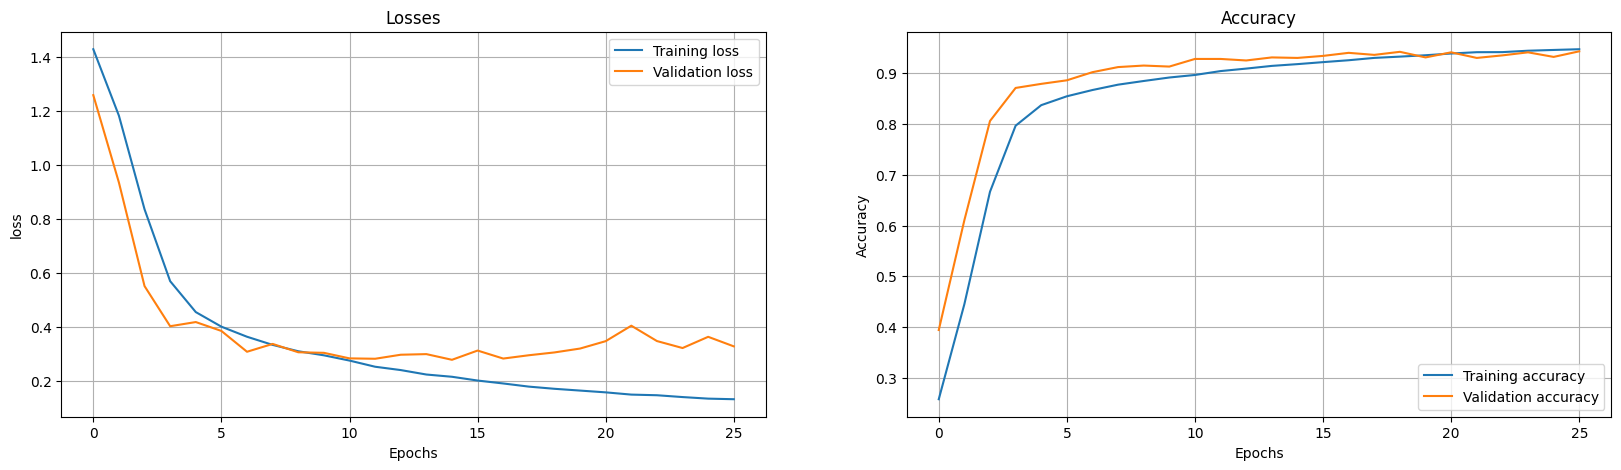

In [49]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [50]:
model.save("model_sentiment", save_format="tf")


INFO:tensorflow:Assets written to: model_sentiment\assets


INFO:tensorflow:Assets written to: model_sentiment\assets


In [52]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [53]:
loaded_model = tf.keras.models.load_model("D:\INSTANT(Course)\Training Month\Sprint3\Sentiment Analysis\model_sentiment")


In [54]:
test_loss, test_accuracy = loaded_model.evaluate(x_test_pad, y_test_categorical, batch_size=32)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


224/224 [==============================] - 5s 19ms/step - loss: 0.5847 - accuracy: 0.8231
Test Loss: 0.5847
Test Accuracy: 0.8231


In [55]:
labels = ['Irrelevant', 'Negative', 'Neutral', 'Positive']


In [56]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


y_pred_prob = loaded_model.predict(x_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)  

y_true = np.argmax(y_test_categorical, axis=1)

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
print(cm)


224/224 [==============================] - 4s 18ms/step
              precision    recall  f1-score   support

  Irrelevant       0.78      0.83      0.81      1254
    Negative       0.90      0.82      0.85      2170
     Neutral       0.78      0.83      0.80      1771
    Positive       0.83      0.82      0.82      1971

    accuracy                           0.82      7166
   macro avg       0.82      0.82      0.82      7166
weighted avg       0.83      0.82      0.82      7166

[[1046   37   92   79]
 [  99 1773  147  151]
 [ 103   91 1465  112]
 [  93   80  184 1614]]


<Axes: >

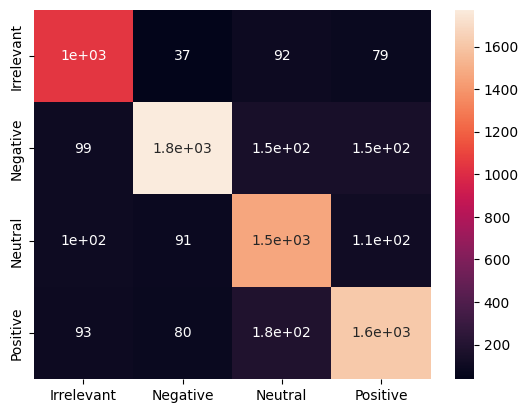

In [57]:
confusion_matrix_df = confusion_matrix(y_true, y_pred)


cm_df = pd.DataFrame(confusion_matrix_df , index=labels, columns=labels)
sns.heatmap(cm_df ,annot = True)